### Global Functional Connectivity analysis

This script reads corelation matrices data na surrogate data and calculate modularity index of a graph
for each time condition separately, and compute betveen subject averaged connectivity from an electrode to the all other electrodes 

*Parameters to consider*:
- nC: a number of conditions per figure (should equal 1 in this version)
- nG: a number of groups
- nS: a number of subjects in a group
- nE: a number of electrodes in a subject


*Inputs*:
- load the correlation matrix files *_true.npy (for true) and *_surr.npy (for surrpgates)
- load an electrode layout file ASA_standard_waveguard64_Layout_noMs.txt
- load a subject position file i.e. 1st_positions.npz
    
*Outputs*:
    save plots to the png images

# Load the correlation matrices

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os

def init_list(dims, val):
    if len(dims) == 0:
        raise ValueError("Requires at least 1 dimension.")
    if len(dims) == 1:
        return [val for _ in range(dims[0])]
    return [init_list(dims[1:], val=val) for _ in range(dims[0])]

inputPath = '/home/koudelka/Projects/AyahuascaMusic/input/'
outputPath = 'C:/FEL/ING/diplomka/data/TG/1/'
pipePath = 'C:/FEL/ING/diplomka/data/TG/1/'
#pipePath = '/home/koudelka/Projects/Ayahuasca2023/2ndCeremony/pipeline/pipe/' 
libPath = '/home/koudelka/git/atin_hyperscan_tool/lib/'

condLab = ['Baseline','TGA', 'TGA']

nC = 3
nG = 1
nS = 2
nE = 64

pwd = os.getcwd()

corrMatObs = init_list((nC,nG),val=0)
corrMatSur = init_list((nC,nG),val=0)
for cIdx in range(0,nC):
    for gIdx in range(0,nG):
        corrMatObs[cIdx][gIdx] = np.load(pipePath + 'c' + str(cIdx) + 'g' + str(gIdx) + '_observed' + '.npy')
        corrMatSur[cIdx][gIdx] = np.load(pipePath + 'c' + str(cIdx) + 'g' + str(gIdx) + '_surrogate' + '.npy')       
        #corrMatObs[cIdx][gIdx] = np.load(pipePath + 'epochs_Alpha_cond_' + str(cIdx) + '_true.npy')
        #corrMatSur[cIdx][gIdx] = np.load(pipePath + 'epochs_Alpha_cond_' + str(cIdx) + '_surr.npy')

#a number of permutations
nP = corrMatSur[0][0].shape[0]       

# Define the function for GFC computation using the connectivity matrix

In [47]:
def get_gfc(mat,nS,nE):

    matrix_size = nS * nE
    subject_indices = {f"Subject-{i}": list(range(i * nE, (i + 1) * nE)) for i in range(nS)}
    average_correlations = np.zeros(matrix_size)

    for i in range(matrix_size):
        # Find which subject the current electrode belongs to
        current_subject = [key for key, val in subject_indices.items() if i in val][0]
        
        # Get indices of electrodes from other subjects
        other_subject_indices = [
            idx for subj, indices in subject_indices.items() if subj != current_subject for idx in indices
        ]
        
        # Compute the average correlation
        between_subject_corrs = mat[i, other_subject_indices]
        average_correlations[i] = np.mean(between_subject_corrs)

    #print("Average Correlations Between Subjects for Each Electrode:")
    #print(average_correlations)

    #check the dimmension
    gfc = np.reshape(average_correlations,(nE,nS))
    #print(average_correlations[0:3])
    #print(gfc[0,0:3])
    gfc = gfc.mean(axis=1)
    return gfc

# Compute the GFC for all conditions

In [48]:
from tqdm import trange
gfc = init_list((nC,nG),val=0)
gfcZ = init_list((nC,nG),val=0)
gfcSur = init_list((nP,1),val=0)

for cIdx in range(0,nC):
    print('Condition ' + condLab[cIdx])
    for gIdx in range(0,nG):
        #get observed GFC
        mat = corrMatObs[cIdx][gIdx]
        mat[np.isnan(mat)] = 0
        syMat = mat + mat.T
        gfc[cIdx][gIdx] = get_gfc(mat=syMat,nS=nS,nE=nE)
        #get GFC in each permutation
        for permIdx in trange(0,nP):
            mat = corrMatSur[cIdx][gIdx][permIdx,:,:]
            mat[np.isnan(mat)] = 0
            syMat = mat + mat.T
            gfcSur[permIdx] = get_gfc(mat=syMat,nS=nS,nE=nE)
        #compute the Z-score
        surMat = np.array(gfcSur) 
        gfcZ[cIdx][gIdx] = (gfc[cIdx][gIdx] - surMat.mean(axis=0)) / surMat.std(axis=0)   
            


Condition icaros


  0%|          | 0/200 [00:00<?, ?it/s]

100%|██████████| 200/200 [00:01<00:00, 112.00it/s]


Condition silece


100%|██████████| 200/200 [00:01<00:00, 111.79it/s]


### Save the computed modularity index

In [49]:
np.save(outputPath + 'global_functional_connectivity', gfcZ)


# Prepare the layout for topo printing

In [50]:
layout = np.loadtxt(libPath + 'ANT64waveguardLay.txt', delimiter="\t", dtype=str)
#change format of the layout to fit to the mne template
plotLayout = layout[:,1:3].astype(np.float64)
#rotate
plotLayout[:,0] = layout[:,2].astype(np.float64)
plotLayout[:,1] = layout[:,1].astype(np.float64)
#rescale
plotLayout = plotLayout/1000.0
plotLabels = np.char.strip(layout[:,0],':')

#make a dictionary for convenience
layout = {'Coords': plotLayout, 'Labels': plotLabels} 

# Plot the mean topomaps

todo: plot matrix of topomaps

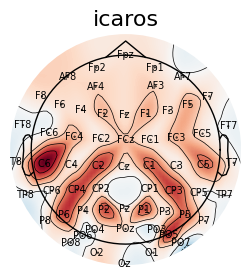

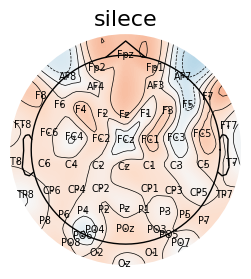

In [51]:
import mne
#fig, ax = plt.subplots(1, nC)
#fig.suptitle('Average GFC topomaps')

gfc = np.array(gfcZ)


for cIdx in range(0,nC):
    #average across groups
    topoGfc = gfc[cIdx,:,:].mean(axis=0)
    maxAbs = np.max(np.abs(gfc.flatten()))
    fig, ax = plt.subplots(figsize=(3, 3))
    ax.set_title(condLab[cIdx], fontsize=16)
    mne.viz.plot_topomap(topoGfc,layout['Coords'], axes=ax, names=layout['Labels'],
                            vlim=(-maxAbs,maxAbs),size=1)